# Adding Performance Metrics to Roles
This notebook integrates performance quality metrics (WAR for MLB, EPA for NFL) with the role-based utility framework built in notebooks 01-02.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Load Existing Data
mlb_roles = pd.read_csv('../data/processed/mlb_roles_with_utility.csv')
season_utility = pd.read_csv('../data/processed/season_utility_scores.csv')

print(f"✓ Loaded {len(mlb_roles):,} MLB role records")
print(f"✓ Loaded {len(season_utility):,} player-seasons")
print(f"✓ Date range: {mlb_roles['season'].min()} - {mlb_roles['season'].max()}")

# Quick check of data structure
print("\nMLB Roles columns:", mlb_roles.columns.tolist())
print("\nSample row:")
print(mlb_roles.head(1).T)

✓ Loaded 311,785 MLB role records
✓ Loaded 116,566 player-seasons
✓ Date range: 1871 - 2024

MLB Roles columns: ['player_id', 'season', 'position', 'time_in_role', 'league', 'total_time', 'role_share', 'utility_score']

Sample row:
                       0
player_id      aardsda01
season              2004
position               P
time_in_role   10.666667
league               MLB
total_time     10.666667
role_share           1.0
utility_score        0.0


In [8]:
# 2. Load WAR Data
# Load batting WAR
war_batting = pd.read_csv('../data/raw/mlb/war_daily_bat.txt', 
                          sep=',', 
                          low_memory=False)

# Load pitching WAR
war_pitching = pd.read_csv('../data/raw/mlb/war_daily_pitch.txt', 
                           sep=',', 
                           low_memory=False)

print(f"✓ Loaded {len(war_batting):,} batting WAR records")
print(f"✓ Loaded {len(war_pitching):,} pitching WAR records")

# Inspect WAR data structure
print("\nBatting WAR columns:", war_batting.columns.tolist())
print("\nPitching WAR columns:", war_pitching.columns.tolist())

✓ Loaded 124,865 batting WAR records
✓ Loaded 56,860 pitching WAR records

Batting WAR columns: ['name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays', 'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement', 'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def', 'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep', 'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep', 'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off', 'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg']

Pitching WAR columns: ['name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID', 'G', 'GS', 'IPouts', 'IPouts_start', 'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extras_adj', 'xRA_def_pitcher', 'PPF', 'PPF_

In [9]:
# 3. Standardize WAR Data

# Aggregate WAR to season level (WAR data is often daily)
# Check if 'year_ID' or 'yearID' exists
year_col = 'year_ID' if 'year_ID' in war_batting.columns else 'yearID'
player_col = 'player_ID' if 'player_ID' in war_batting.columns else 'playerID'

# Batting WAR - aggregate to season
batting_war_season = war_batting.groupby([player_col, year_col]).agg({
    'WAR': 'sum',  # Sum daily WAR to get season total
    'runs_bat': 'sum',
    'runs_br': 'sum', 
    'runs_dp': 'sum',
    'runs_field': 'sum'
}).reset_index()

batting_war_season.columns = ['player_id', 'season', 'WAR_bat', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field']

# Pitching WAR - aggregate to season
pitching_war_season = war_pitching.groupby([player_col, year_col]).agg({
    'WAR': 'sum'
}).reset_index()

pitching_war_season.columns = ['player_id', 'season', 'WAR_pitch']

print(f"✓ Aggregated to {len(batting_war_season):,} batting seasons")
print(f"✓ Aggregated to {len(pitching_war_season):,} pitching seasons")

✓ Aggregated to 115,050 batting seasons
✓ Aggregated to 52,132 pitching seasons


In [7]:
import pandas as pd

# Load just the first few rows to inspect
war_batting = pd.read_csv('../data/raw/mlb/war_daily_bat.txt', sep='\t', nrows=5)
war_pitching = pd.read_csv('../data/raw/mlb/war_daily_pitch.txt', sep='\t', nrows=5)

print("="*60)
print("BATTING WAR COLUMNS:")
print("="*60)
print(war_batting.columns.tolist())
print("\nFirst row:")
print(war_batting.head(1).T)

print("\n" + "="*60)
print("PITCHING WAR COLUMNS:")
print("="*60)
print(war_pitching.columns.tolist())
print("\nFirst row:")
print(war_pitching.head(1).T)

BATTING WAR COLUMNS:
['name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg']

First row:
                                                                                                    0
name_common,age,mlb_ID,player_ID,year_ID,team_I...  David Aardsma,22,430911,aardsda01,2004,SFG,1,N...

PITCHING WAR COLUMNS:
['name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,G,GS,IPouts,IPouts_start,IPouts_relief,RA,xRA,xRA_sprp_adj,xRA_extras_adj,xRA_def_pitcher,PPF,PPF_custom,xRA_final,BIP,BIP_perc,RS_def_total,runs_above_avg,ru

In [10]:
# 4. Join Performance to Roles

# Start with a copy of the role data
mlb_roles_perf = mlb_roles.copy()

# Join batting performance (for HITTER role AND fielding positions)
mlb_roles_perf = mlb_roles_perf.merge(
    batting_war_season,
    on=['player_id', 'season'],
    how='left'
)

# Join pitching performance (for P role)
mlb_roles_perf = mlb_roles_perf.merge(
    pitching_war_season,
    on=['player_id', 'season'],
    how='left'
)

# Create unified performance column based on role type
def assign_performance_value(row):
    """
    Assign appropriate performance metric based on position:
    - HITTER role: Use offensive WAR components
    - P role: Use pitching WAR
    - Fielding positions: Use offensive + fielding components
    """
    if pd.isna(row['position']):
        return 0
    
    if row['position'] == 'P':
        # Pitchers: use pitching WAR
        return row['WAR_pitch'] if pd.notna(row['WAR_pitch']) else 0
    
    elif row['position'] == 'HITTER':
        # Pure hitting role: use batting runs only
        if pd.notna(row['runs_bat']):
            return row['runs_bat'] / 10  # Convert runs to WAR-like scale
        return 0
    
    else:
        # Fielding positions: combine batting + fielding
        batting_value = row['runs_bat'] if pd.notna(row['runs_bat']) else 0
        fielding_value = row['runs_field'] if pd.notna(row['runs_field']) else 0
        baserunning = row['runs_br'] if pd.notna(row['runs_br']) else 0
        
        # Total value in WAR scale (10 runs = 1 WAR)
        return (batting_value + fielding_value + baserunning) / 10

# Apply performance assignment
mlb_roles_perf['performance_value'] = mlb_roles_perf.apply(assign_performance_value, axis=1)

print(f"✓ Assigned performance values to {len(mlb_roles_perf):,} role records")
print(f"✓ Non-zero performance values: {(mlb_roles_perf['performance_value'] != 0).sum():,}")


✓ Assigned performance values to 311,785 role records
✓ Non-zero performance values: 297,513


In [13]:
# Check for missing values
print(f"Rows with missing player_id: {mlb_roles_perf['player_id'].isna().sum()}")
print(f"Rows with missing season: {mlb_roles_perf['season'].isna().sum()}")

# Remove rows with missing player_id or season
mlb_roles_perf_clean = mlb_roles_perf.dropna(subset=['player_id', 'season'])
print(f"Cleaned data: {len(mlb_roles_perf_clean):,} rows (removed {len(mlb_roles_perf) - len(mlb_roles_perf_clean):,})")

# For each player-season, calculate weighted average performance
def calculate_weighted_stats(group):
    """Calculate weighted performance with error handling"""
    weighted_perf = (group['role_share'] * group['performance_value']).sum()
    total_perf = group['performance_value'].sum()
    n_roles = len(group)
    
    # Handle primary position safely
    if group['role_share'].notna().any():
        max_idx = group['role_share'].idxmax()
        if pd.notna(max_idx):
            primary_pos = group.loc[max_idx, 'position']
        else:
            primary_pos = group.iloc[0]['position']  # fallback to first position
    else:
        primary_pos = group.iloc[0]['position']  # fallback to first position
    
    return pd.Series({
        'weighted_performance': weighted_perf,
        'total_performance': total_perf,
        'n_roles': n_roles,
        'primary_position': primary_pos
    })

weighted_performance = mlb_roles_perf_clean.groupby(['player_id', 'season']).apply(
    calculate_weighted_stats
).reset_index()

# Merge utility scores
weighted_performance = weighted_performance.merge(
    season_utility[['player_id', 'season', 'utility_score']],
    on=['player_id', 'season'],
    how='left'
)

print(f"✓ Calculated weighted performance for {len(weighted_performance):,} player-seasons")

# Summary statistics
print("\nWeighted Performance Summary:")
print(weighted_performance['weighted_performance'].describe())
print(f"\nUtility Score Summary:")
print(weighted_performance['utility_score'].describe())

Rows with missing player_id: 0
Rows with missing season: 0
Cleaned data: 311,785 rows (removed 0)
✓ Calculated weighted performance for 116,566 player-seasons

Weighted Performance Summary:
count    116566.000000
mean          0.266147
std           1.351567
min          -6.513000
25%          -0.271750
50%           0.000000
75%           0.375000
max          20.376734
Name: weighted_performance, dtype: float64

Utility Score Summary:
count    116566.000000
mean          0.075024
std           0.181077
min           0.000000
25%           0.000000
50%          -0.000000
75%           0.000000
max           1.000000
Name: utility_score, dtype: float64


C:\Users\Thshi\AppData\Local\Temp\ipykernel_13428\1862842373.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_performance = mlb_roles_perf_clean.groupby(['player_id', 'season']).apply(


In [ ]:
# 6. Save Outputs

# Save role-level data with performance
mlb_roles_perf.to_csv('data/processed/mlb_roles_with_performance.csv', index=False)
print(f"✓ Saved: data/processed/mlb_roles_with_performance.csv")

# Save season-level weighted performance
weighted_performance.to_csv('data/processed/mlb_weighted_performance.csv', index=False)
print(f"✓ Saved: data/processed/mlb_weighted_performance.csv")


VALIDATION CHECKS

[Check 1] Performance Value Distribution
             count      mean       std    min     25%     50%      75%     max
position                                                                      
1B         16255.0  0.154061  1.410094 -5.281 -0.5870 -0.0920  0.49600  12.867
2B         15564.0 -0.268738  1.229049 -6.513 -0.8750 -0.2830  0.06500   9.963
3B         16628.0 -0.167511  1.244226 -6.513 -0.8000 -0.2400  0.14900   9.545
C          13036.0 -0.268029  0.867247 -4.428 -0.6890 -0.2160  0.00000   7.601
HITTER     98586.0 -0.094548  1.021488 -6.405 -0.5360 -0.1280  0.02200  11.632
OF         33640.0  0.141821  1.334265 -5.522 -0.5270 -0.0740  0.41925  12.867
P         104054.0  0.751598  1.710252 -5.290 -0.2000  0.1500  1.24000  20.450
PH           167.0 -0.011377  0.200247 -1.008 -0.0265  0.0000  0.00000   1.154
PR            21.0 -0.009952  0.069362 -0.231  0.0000  0.0000  0.00000   0.182
SS         13834.0 -0.339767  1.299029 -6.843 -0.9920 -0.3305  0.03800

C:\Users\Thshi\AppData\Local\Temp\ipykernel_13428\678348490.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([weighted_performance[weighted_performance['n_roles'] == i]['weighted_performance'].dropna()



✓ Saved visualization: outputs/phase1_performance_analysis.png


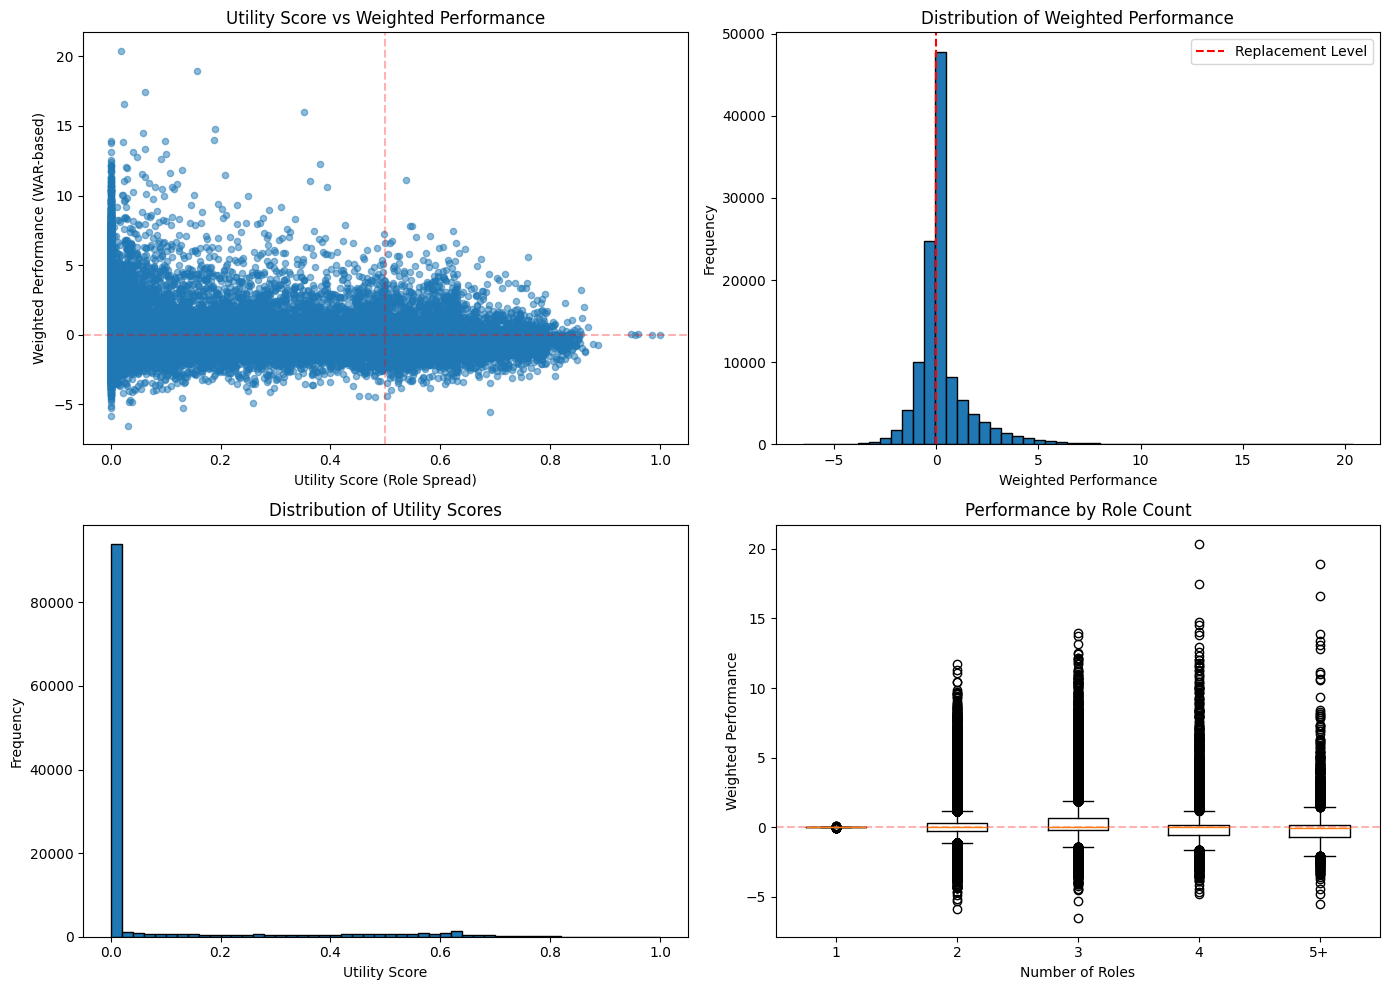

In [16]:
# 7. Validation & Visualization

print("\n" + "="*60)
print("VALIDATION CHECKS")
print("="*60)

# Check 1: Performance distribution
print("\n[Check 1] Performance Value Distribution")
print(mlb_roles_perf.groupby('position')['performance_value'].describe())

# Check 2: Top utility players with performance
print("\n[Check 2] Top 10 Utility Players by Utility Score")
top_utility = weighted_performance.nlargest(10, 'utility_score')[
    ['player_id', 'season', 'utility_score', 'weighted_performance', 'n_roles', 'primary_position']
]
print(top_utility.to_string(index=False))

# Check 3: Top performers
print("\n[Check 3] Top 10 Players by Weighted Performance")
top_performers = weighted_performance.nlargest(10, 'weighted_performance')[
    ['player_id', 'season', 'weighted_performance', 'utility_score', 'n_roles', 'primary_position']
]
print(top_performers.to_string(index=False))

# Visualization: Utility vs Performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Utility vs Weighted Performance
axes[0, 0].scatter(weighted_performance['utility_score'], 
                   weighted_performance['weighted_performance'],
                   alpha=0.5, s=20)
axes[0, 0].set_xlabel('Utility Score (Role Spread)')
axes[0, 0].set_ylabel('Weighted Performance (WAR-based)')
axes[0, 0].set_title('Utility Score vs Weighted Performance')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 0].axvline(x=0.5, color='r', linestyle='--', alpha=0.3)

# Plot 2: Performance distribution
axes[0, 1].hist(weighted_performance['weighted_performance'], bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Weighted Performance')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Weighted Performance')
axes[0, 1].axvline(x=0, color='r', linestyle='--', label='Replacement Level')
axes[0, 1].legend()

# Plot 3: Utility score distribution
axes[1, 0].hist(weighted_performance['utility_score'], bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Utility Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Utility Scores')

# Plot 4: Number of roles vs performance
axes[1, 1].boxplot([weighted_performance[weighted_performance['n_roles'] == i]['weighted_performance'].dropna() 
                     for i in range(1, 6)],
                    labels=['1', '2', '3', '4', '5+'])
axes[1, 1].set_xlabel('Number of Roles')
axes[1, 1].set_ylabel('Weighted Performance')
axes[1, 1].set_title('Performance by Role Count')
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/performance_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization: outputs/phase1_performance_analysis.png")